In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
import os
import matplotlib.pyplot as plt
import glob
import cv2
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
IMAGE_SIZE = (128, 128)

train_path = "D:/Tasks/Coconut/dataset/train"
val_path = "D:/Tasks/Coconut/dataset/val"

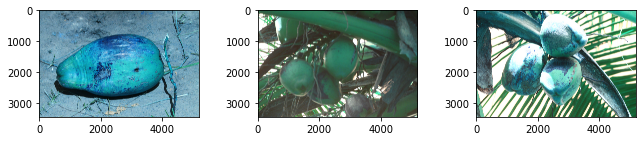

In [4]:
import random
from PIL import Image 

images = []
for folder in os.listdir(train_path):
    for image in os.listdir(train_path + '/' + folder):
        images.append(os.path.join(train_path, folder, image))

plt.figure(1, figsize=(15, 9))
plt.axis('off')
n = 0
for i in range(3):
  n += 1
  random_img = random.choice(images)
  imgs = cv2.imread(random_img)
  plt.subplot(4, 4, n)
  plt.imshow(imgs)

plt.show()

In [5]:
train_generator = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest' )

train_set = train_generator.flow_from_directory(train_path,
                                                target_size = IMAGE_SIZE,
                                                shuffle=True,
                                                batch_size = 32 )


test_set = ImageDataGenerator().flow_from_directory(val_path,
                                            target_size = IMAGE_SIZE,
                                            batch_size = 32, 
                                            shuffle=False )

Found 1004 images belonging to 4 classes.
Found 252 images belonging to 4 classes.


In [6]:
CLASS_NUM = 4

### DenseNet201

In [7]:
denseNet = tf.keras.applications.densenet.DenseNet201(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3),
    pooling="avg",
    classes=CLASS_NUM,
)

In [8]:
denseNet.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/conv[0][0]']   

In [9]:
for layer in denseNet.layers[:-5]:
    layer.trainable = False

In [10]:
input_layer = tf.keras.layers.Input(shape=(128,128,3))

denseNet_preprocess = tf.keras.layers.Lambda(tf.keras.applications.densenet.preprocess_input)(input_layer)

densenet_output = denseNet(denseNet_preprocess)
densenet_output = tf.keras.layers.Flatten()(densenet_output)

denseNet_output = tf.keras.layers.Dense(CLASS_NUM, activation='softmax')(densenet_output)

In [11]:
denseNet_model = keras.models.Model(inputs=input_layer, outputs=denseNet_output)

In [12]:
denseNet_model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
denseNet_history = denseNet_model.fit(
    train_set,
    validation_data=test_set,
    epochs=10
)

Epoch 1/10
32/32 [==============================] - 504s 16s/step - loss: 0.7424 - accuracy: 0.6962 - val_loss: 0.4669 - val_accuracy: 0.7937
Epoch 2/10
32/32 [==============================] - 494s 16s/step - loss: 0.4255 - accuracy: 0.8167 - val_loss: 0.3812 - val_accuracy: 0.8214
Epoch 3/10
32/32 [==============================] - 458s 14s/step - loss: 0.3577 - accuracy: 0.8396 - val_loss: 0.3380 - val_accuracy: 0.8492
Epoch 4/10
32/32 [==============================] - 449s 14s/step - loss: 0.3498 - accuracy: 0.8496 - val_loss: 0.3498 - val_accuracy: 0.8532
Epoch 5/10
32/32 [==============================] - 450s 14s/step - loss: 0.3108 - accuracy: 0.8556 - val_loss: 0.3117 - val_accuracy: 0.8651
Epoch 6/10
32/32 [==============================] - 446s 14s/step - loss: 0.3261 - accuracy: 0.8566 - val_loss: 0.3432 - val_accuracy: 0.8413
Epoch 7/10
32/32 [==============================] - 449s 14s/step - loss: 0.2719 - accuracy: 0.8914 - val_loss: 0.3317 - val_accuracy: 0.8571
Epoch 

In [14]:
train_loss, train_acc = denseNet_model.evaluate(train_set)

32/32 [==============================] - 359s 11s/step - loss: 0.2414 - accuracy: 0.8984


In [15]:
test_loss, test_acc = denseNet_model.evaluate(test_set)

8/8 [==============================] - 110s 14s/step - loss: 0.3177 - accuracy: 0.8532


### ResNet50

In [16]:
resNet = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3),
    pooling="avg",
    classes=CLASS_NUM,
)

In [17]:
resNet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

In [18]:
for layer in resNet.layers[:-4]:
    layer.trainable = False

In [19]:
input_layer = tf.keras.layers.Input(shape=(128,128,3))

resNet_preprocess = tf.keras.layers.Lambda(tf.keras.applications.resnet50.preprocess_input)(input_layer)

resNet_output = resNet(resNet_preprocess)
resNet_output = tf.keras.layers.Flatten()(resNet_output)

resNet_output = tf.keras.layers.Dense(CLASS_NUM, activation='softmax')(resNet_output)

In [20]:
resNet_model = keras.models.Model(inputs=input_layer, outputs=resNet_output)

In [21]:
resNet_model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [22]:
resNet_history = resNet_model.fit(
    train_set,
    validation_data=test_set,
    epochs=10
)

Epoch 1/10
32/32 [==============================] - 482s 15s/step - loss: 0.7269 - accuracy: 0.6922 - val_loss: 0.4250 - val_accuracy: 0.7937
Epoch 2/10
32/32 [==============================] - 35009s 1129s/step - loss: 0.3789 - accuracy: 0.8217 - val_loss: 0.3884 - val_accuracy: 0.8254
Epoch 3/10
32/32 [==============================] - 514s 16s/step - loss: 0.3522 - accuracy: 0.8416 - val_loss: 0.3695 - val_accuracy: 0.8333
Epoch 4/10
32/32 [==============================] - 441s 14s/step - loss: 0.3271 - accuracy: 0.8466 - val_loss: 0.3064 - val_accuracy: 0.8690
Epoch 5/10
32/32 [==============================] - 479s 15s/step - loss: 0.3245 - accuracy: 0.8546 - val_loss: 0.2941 - val_accuracy: 0.8770
Epoch 6/10
32/32 [==============================] - 470s 15s/step - loss: 0.3003 - accuracy: 0.8715 - val_loss: 0.2953 - val_accuracy: 0.8889
Epoch 7/10
32/32 [==============================] - 471s 15s/step - loss: 0.2870 - accuracy: 0.8765 - val_loss: 0.2936 - val_accuracy: 0.9008
Ep

In [23]:
train_loss, train_acc = resNet_model.evaluate(train_set)

32/32 [==============================] - 375s 12s/step - loss: 0.2310 - accuracy: 0.9064


In [24]:
test_loss, test_acc = resNet_model.evaluate(test_set)

8/8 [==============================] - 106s 14s/step - loss: 0.2753 - accuracy: 0.8968


### MobileNet

In [25]:
mobileNet = tf.keras.applications.mobilenet.MobileNet(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3),
    pooling="avg",
    classes=CLASS_NUM,
)

In [26]:
mobileNet.summary()

Model: "mobilenet_1.00_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                         

In [27]:
for layer in mobileNet.layers[:-3]:
    layer.trainable = False

In [28]:
input_layer = tf.keras.layers.Input(shape=(128,128,3))

mobileNet_preprocess = tf.keras.layers.Lambda(tf.keras.applications.mobilenet.preprocess_input)(input_layer)

mobileNet_output = mobileNet(mobileNet_preprocess)
mobileNet_output = tf.keras.layers.Flatten()(mobileNet_output)

mobileNet_output = tf.keras.layers.Dense(CLASS_NUM, activation='softmax')(mobileNet_output)

In [29]:
mobileNet_model = keras.models.Model(inputs=input_layer, outputs=mobileNet_output)

In [30]:
mobileNet_model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [31]:
mobileNet_history = mobileNet_model.fit(
    train_set,
    validation_data=test_set,
    epochs=10
)

Epoch 1/10
32/32 [==============================] - 491s 15s/step - loss: 0.8895 - accuracy: 0.6295 - val_loss: 0.5451 - val_accuracy: 0.7540
Epoch 2/10
32/32 [==============================] - 492s 16s/step - loss: 0.4918 - accuracy: 0.7789 - val_loss: 0.4529 - val_accuracy: 0.7976
Epoch 3/10
32/32 [==============================] - 490s 15s/step - loss: 0.3990 - accuracy: 0.8177 - val_loss: 0.3965 - val_accuracy: 0.8373
Epoch 4/10
32/32 [==============================] - 473s 15s/step - loss: 0.3503 - accuracy: 0.8486 - val_loss: 0.4422 - val_accuracy: 0.8254
Epoch 5/10
32/32 [==============================] - 453s 14s/step - loss: 0.3480 - accuracy: 0.8347 - val_loss: 0.3934 - val_accuracy: 0.8532
Epoch 6/10
32/32 [==============================] - 449s 14s/step - loss: 0.3257 - accuracy: 0.8566 - val_loss: 0.3318 - val_accuracy: 0.8730
Epoch 7/10
32/32 [==============================] - 439s 14s/step - loss: 0.3053 - accuracy: 0.8616 - val_loss: 0.3794 - val_accuracy: 0.8413
Epoch 

In [32]:
train_loss, train_acc = mobileNet_model.evaluate(train_set)

32/32 [==============================] - 367s 11s/step - loss: 0.2533 - accuracy: 0.8805


In [33]:
test_loss, test_acc = mobileNet_model.evaluate(test_set)

8/8 [==============================] - 98s 12s/step - loss: 0.3095 - accuracy: 0.8889


In [34]:
def plot_history(model, history):
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.axis(ymin=0.4,ymax=1)
    plt.grid()
    plt.title(f'{model.name} accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.grid()
    plt.title(f'{model.name} loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

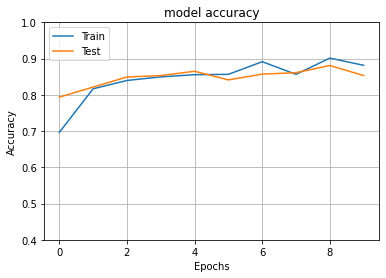

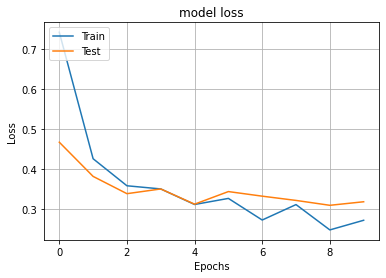

In [35]:
plot_history(denseNet_model, denseNet_history)

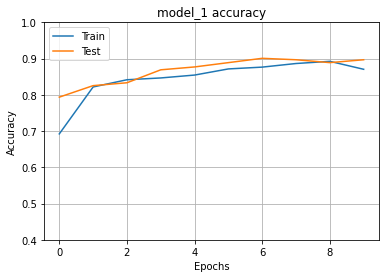

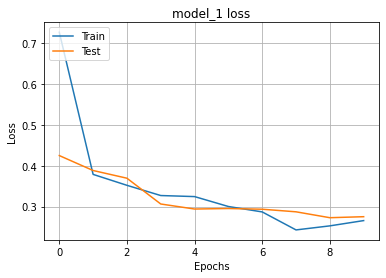

In [36]:
plot_history(resNet_model, resNet_history)

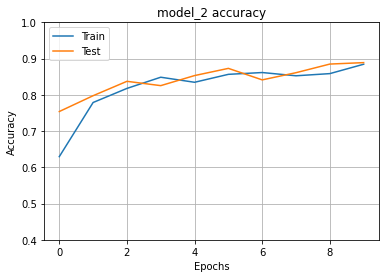

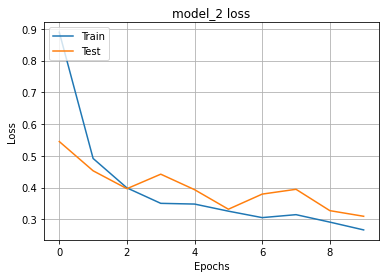

In [37]:
plot_history(mobileNet_model, mobileNet_history)